# met 831 EX1  Gordeev Egor

In [1]:
import sys
import xarray as xr
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import det, inv, eig

In [2]:
from jupyterthemes import jtplot
# currently installed theme will be used to
# set plot style if no arguments provided
jtplot.style()
jtplot.style(theme='chesterish')

In [3]:
np.sin(np.pi/2)

1.0

In [4]:
fname='tHAMBURG-FUHLS.nc'
ds = xr.open_dataset(fname,decode_times=False)

In [5]:
df=ds.to_dataframe()
df

,temp
time,
8412.0,1.1
8413.0,1.4
8414.0,1.9
8415.0,7.0
8416.0,10.9
...,...
8899.0,17.1
8900.0,14.7
8901.0,9.3


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 492 entries, 8412.0 to 8903.0
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    492 non-null    float32
dtypes: float32(1)
memory usage: 5.8 KB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb8bde88e10>]],
      dtype=object)

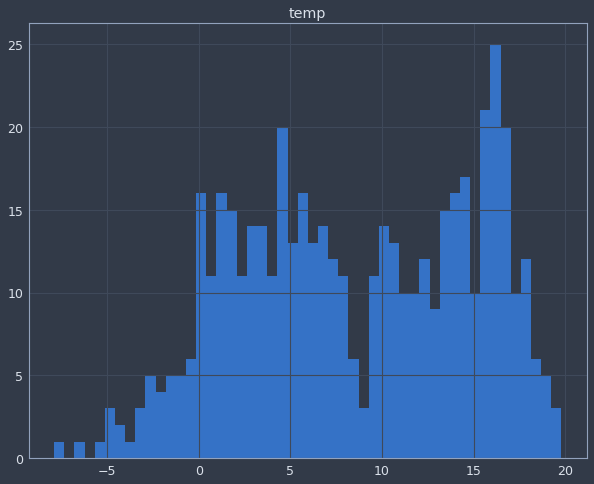

In [7]:
df.hist(bins=50,figsize=(10,8))

Distribution looks almost like a sum of two normal distribution. One with the mean around 15 degress (summer) and the other with the mean around 4 degrees (winter)

In [8]:
time=np.arange(len(ds.time))

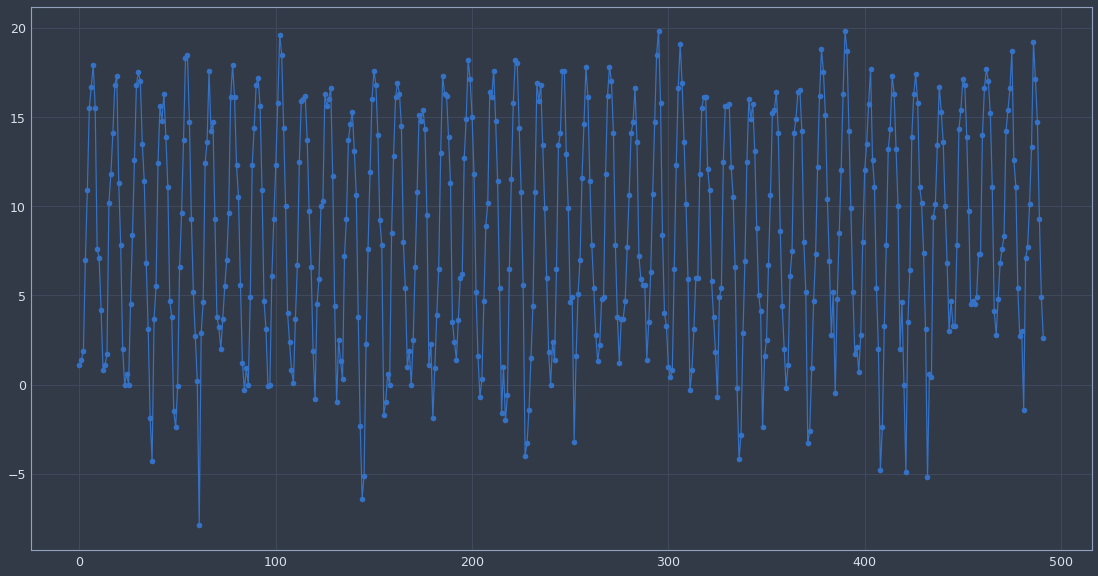

In [9]:
fig= plt.figure(figsize=(19,10))
plt.plot(time,ds.temp,"-o")

## EX1  TASK
Remove the annual cycle from the data and try to look at underlying linear temperature increase trend. 
- There are 492 time entries, 1 entry for each month - 41 years of obervation
- There are 492 corresponding temperature entries
- Fit the data with sin and linear function 
- vector X - temperature entries. X is a sum of deterministic part and noise (stochastic) <br>
Determenistic part is represented through combination of k a-priori defined guess patterns (each k entry is a vector of length n=492) <br>
H0= mean temperature values, n entries <br>
H1= Linear trend (y=ax+b), n entries <br>
H2= Sin function, n entries

Lets represent our signal as a combination of constant, linear trend sine and cosine functions. These will be our "guess patterns". Solving the inverse problem we will find the contributions (amplitudes) of each of these patterns in the signal. <br> <br>
This task is classified as MULTIPLE LINEAR REGRESSION, because we try to predict a value based on two or more variables. 

In [13]:
whos

Variable   Type         Data/Info
---------------------------------
det        function     <function det at 0x7fb8bf8b0710>
df         DataFrame            temp\ntime       <...>n\n[492 rows x 1 columns]
ds         Dataset      <xarray.Dataset>\nDimensi<...>.temperature.inv HAMBU...
eig        function     <function eig at 0x7fb8bf8ab170>
fig        Figure       Figure(1368x720)
fname      str          tHAMBURG-FUHLS.nc
inv        function     <function inv at 0x7fb8bf8b0680>
jtplot     module       <module 'jupyterthemes.jt<...>jupyterthemes/jtplot.py'>
np         module       <module 'numpy' from '/ho<...>kages/numpy/__init__.py'>
os         module       <module 'os' from '/home/<...>da3/lib/python3.7/os.py'>
plt        module       <module 'matplotlib.pyplo<...>es/matplotlib/pyplot.py'>
sys        module       <module 'sys' (built-in)>
time       ndarray      492: 492 elems, type `int64`, 3936 bytes
xr         module       <module 'xarray' from '/h<...>ages/xarray/__init__.py'>


In [14]:
n=len(ds.time)
X=ds.temp.values
# initialize guess vectors
H0=np.ones(n) # constant
H1=time # linear trend
fs=0.52 # frequency
H2=np.sin(2*np.pi*time/12) # sine function of fs Hz
fc=0.53
H3=np.cos(2*np.pi*time/12) # cosine function of fs Hz

In [1]:
np.sin?

Object `np.sin` not found.


In [17]:
H=np.stack([H0,H1,H2,H3],axis=1)
H.shape

(492, 4)

### Apply Least square solution of the inverse problem

sin "max" frequency is 0.06999999999999999


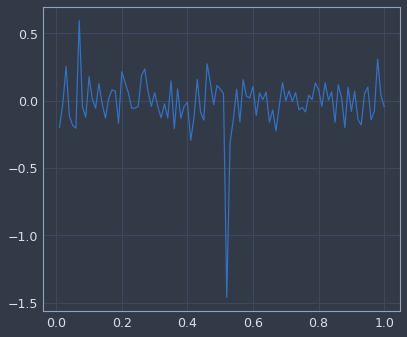

In [18]:
# Here I'm trying to find out the frequency of sin for which the correspondiong 
# coefficients will be the largest. I change the sin frequency while the rest of guess patterns
# are fixed. But probably I need to change the sin/cos parameters at the same time...??
# This frequency if later used in to create the sin "guess pattern"
sinD=[]
freqs=np.linspace(0.01,1,100)
for f in freqs:
    H[:,2]=np.sin(f*time)
    a=inv(H.T@H)@H.T@X
    sinD.append(a[2])
plt.plot(freqs,sinD)
sindD = np.array(sinD)
maxfr = freqs[np.argmax(sinD)]
print(f'sin "max" frequency is {maxfr}')

In [19]:
# least square solution of linear inverse problem X=Ha
a=inv(H.T@H)@H.T@X
a

array([ 8.15816679e+00,  1.72051543e-03, -4.29890299e-02, -8.52046908e+00])

In [20]:
# a[0]=8.04. It's an "amplitude" of a constant guess patter.  
# The value  is quite close to the Temperature mean 
X.mean()

8.580488

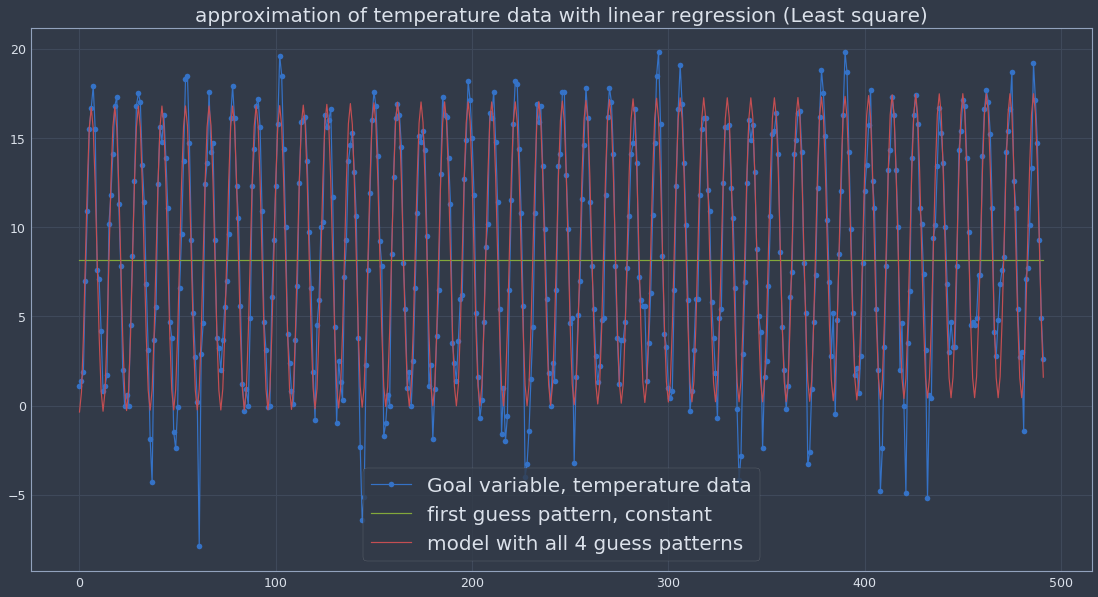

In [22]:
fig= plt.figure(figsize=(19,10))
plt.title("approximation of temperature data with linear regression (Least square)",fontsize=20)
plt.plot(time,ds.temp,"-o",label="Goal variable, temperature data")
plt.plot(a[0]*H[:,0],label='first guess pattern, constant')
plt.plot(a[0]*H[:,0]+a[1]*H[:,1]+a[2]*H[:,2]+a[3]*H[:,3],label="model with all 4 guess patterns")
plt.legend(fontsize=20)

### Apply linear regression from sklearn

In [23]:
from sklearn import linear_model

In [24]:
model = linear_model.LinearRegression()

In [25]:
model.fit(H, X)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [26]:
a_skl=model.coef_
print(f'sklearn coefficents : {a_skl}')
print(f'least square coefficents : {a}')

sklearn coefficents : [ 0.00000000e+00  1.72051543e-03 -4.29890299e-02 -8.52046908e+00]
least square coefficents : [ 8.15816679e+00  1.72051543e-03 -4.29890299e-02 -8.52046908e+00]


In [31]:
a_skl

array([ 0.00000000e+00,  1.72051543e-03, -4.29890299e-02, -8.52046908e+00])

We got exactly the same amplitudes values for all guess patterns as in Least square method, except the first guess pattern (constant) amplitude. I'm not sure why this is so...

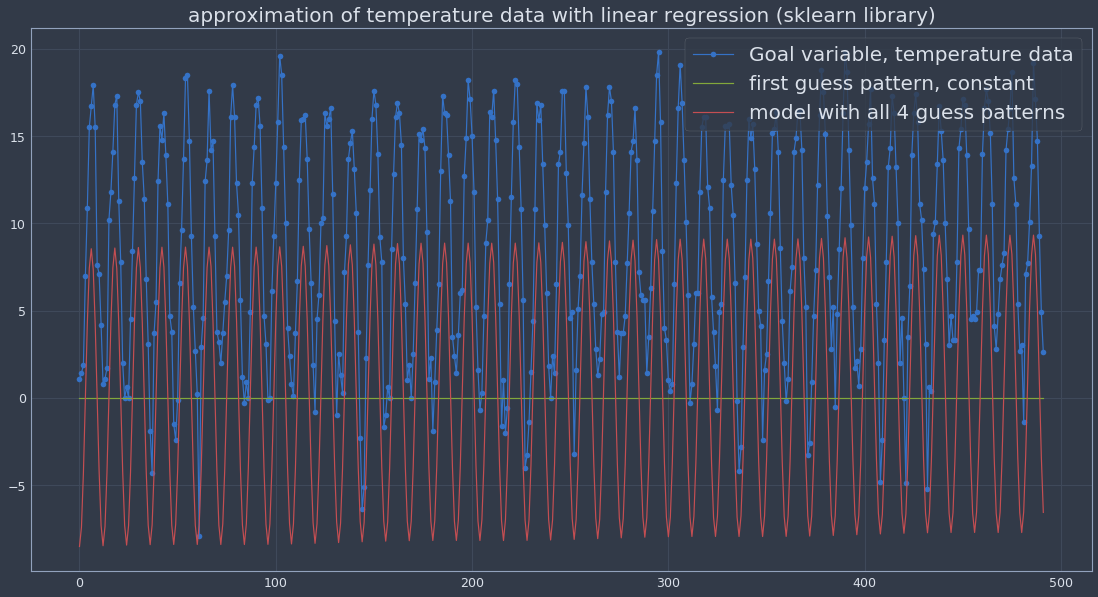

In [27]:
fig= plt.figure(figsize=(19,10))
plt.title("approximation of temperature data with linear regression (sklearn library)",fontsize=20)
plt.plot(time,ds.temp,"-o",label="Goal variable, temperature data")
plt.plot(a_skl[0]*H[:,0],label='first guess pattern, constant')
plt.plot(a_skl[0]*H[:,0]+a_skl[1]*H[:,1]+a_skl[2]*H[:,2]+a_skl[3]*H[:,3],label="model with all 4 guess patterns")
plt.legend(fontsize=20)

### Apply Least square solution of the inverse problem

## Apply the regression to the anomaly (deviation from the mean data)

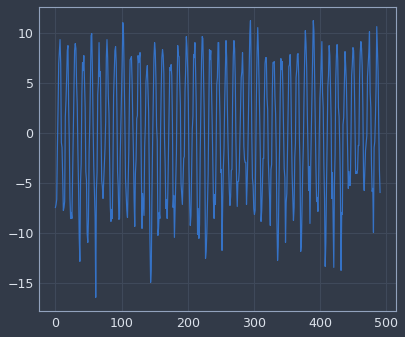

In [28]:
Xdev=X-X.mean()
plt.plot(Xdev)

In [29]:
# least square solution of linear inverse problem X=Ha
a=inv(H.T@H)@H.T@Xdev
print(f'sklearn coefficents : {a_skl}')
print(f'least square coefficents (anomaly) : {a}')

sklearn coefficents : [ 0.00000000e+00  1.72051543e-03 -4.29890299e-02 -8.52046908e+00]
least square coefficents (anomaly) : [-4.22321418e-01  1.72051546e-03 -4.29890396e-02 -8.52046907e+00]


We got the essantially the same coefficients except the 1st one (expectedly)

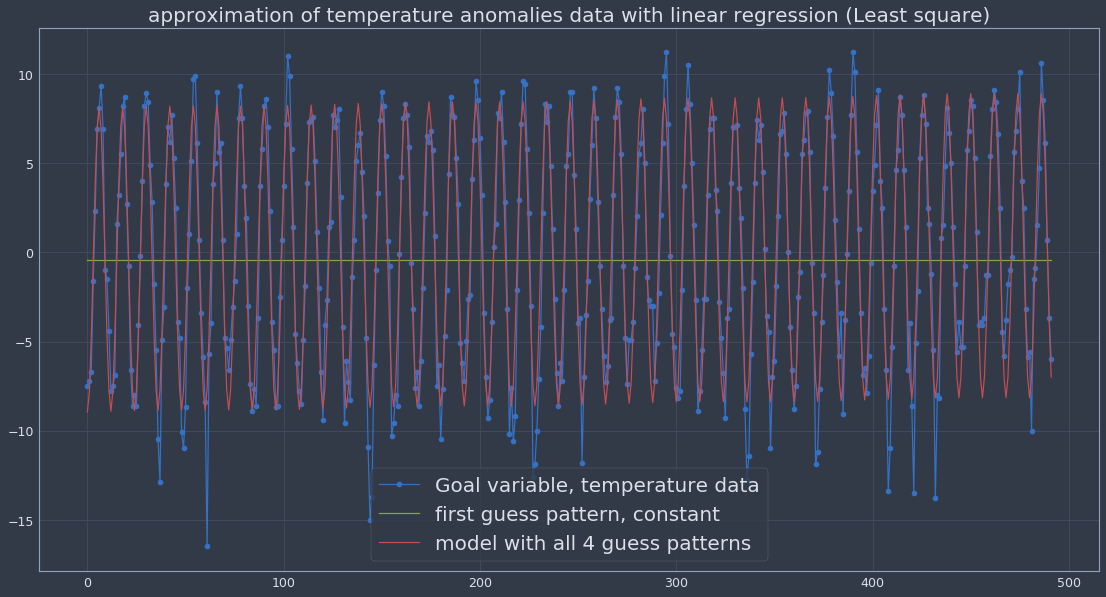

In [30]:
fig= plt.figure(figsize=(19,10))
plt.title("approximation of temperature anomalies data with linear regression (Least square)",fontsize=20)
plt.plot(time,Xdev,"-o",label="Goal variable, temperature data")
plt.plot(a[0]*H[:,0],label='first guess pattern, constant')
plt.plot(a[0]*H[:,0]+a[1]*H[:,1]+a[2]*H[:,2]+a[3]*H[:,3],label="model with all 4 guess patterns")
plt.legend(fontsize=20)